# **Comparative Analysis of GDP and HDI Brazil**

[Source](https://datahub.io/core/gdp#data) and [License](https://opendatacommons.org/licenses/pddl/1-0/) of the dataset (GDP).

[Source](https://hdr.undp.org/data-center/documentation-and-downloads) and [License](https://hdr.undp.org/terms-use) of the indicators.

## Otávio Marinho

## Introduction

This project explores economic and social indicators to answer key questions about Brazil's positioning in the global scenario. We analyze data on GDP, economic growth, and the Human Development Index (HDI), with a special focus on developing countries, developed countries, and the BRICS.

## Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Import and Loading  
Global economic data and composite quality of life indices for analysis.

In [10]:
# GDP Data
gdp_data = pd.read_csv("gdp_data.csv", index_col=None)

# Composite Indices Data
composite_indices = pd.read_csv('composite_indices.csv', index_col=None)

## Data Cleaning and Preprocessing

Columns with improper formats were identified, including numeric values stored as text with incorrect punctuation. To convert these to float format, it was necessary to remove the thousands separators. Additionally, adjustments were needed for the HDI column, where some records had three decimal places and exceeded the maximum limit of 1, requiring correction.

In [11]:
in_development_countries = [
    'ARG', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN', 'BOL',
    'IND', 'PAK', 'BGD', 'NGA', 'ETH', 'KEN', 'MOZ', 'ZAF', 'EGY', 'MAR', 'IDN', 'PHL',
    'VNM', 'THA', 'TUR', 'UZB', 'SDN', 'YEM', 'LKA'
]
developed_countries = [
    'USA', 'CAN', 'GBR', 'FRA', 'DEU', 'ITA', 'JPN', 'AUS', 'NZL', 'KOR', 'NLD', 'DNK',
    'NOR', 'SWE', 'FIN', 'CHE', 'BEL', 'AUT', 'PRT', 'ISL', 'IRL', 'ESP', 'GRC', 'LUX',
    'HUN', 'CZE', 'POL', 'SVK', 'LTU', 'LVA', 'EST'
]

# Filtering relevant data
gdp_data_cleaned = gdp_data[gdp_data['Country Code'].isin(in_development_countries + developed_countries)]
gdp_data_cleaned['is_developed'] = gdp_data_cleaned['Country Code'].isin(developed_countries)

# Extraction of columns
country_codes = composite_indices.iloc[:, 0]
hdi_data = composite_indices.loc[:, 'hdi_2022']
life_expectancy_data = composite_indices.loc[:, 'le_2022']
population_data = composite_indices.loc[:, 'pop_total_2022']
gnipc_data = composite_indices.loc[:, 'gnipc_2022']

# Creating a new df
world_data = pd.concat([country_codes, hdi_data, life_expectancy_data, population_data, gnipc_data], axis=1)

# Adjusting HDI format
def format_hdi(value):
    try:
        if value > 1:
            value = value / 1000
        return round(value, 3)
    except Exception as e:
        return value

world_data['hdi_2022'] = world_data['hdi_2022'].apply(format_hdi)

# Converting Columns
def convert_to_float(value, is_le=False):
    try:
        if is_le:
            return float(value)
        else:
            value = value.replace('.', '')
            return float(value)
    except:
        return np.nan

world_data['le_2022'] = world_data['le_2022'].apply(convert_to_float, is_le=True)
cols_to_convert = ['pop_total_2022', 'gnipc_2022']
for col in cols_to_convert:
    world_data[col] = world_data[col].apply(convert_to_float)

## Exploratory Analysis

### Economic Growth of Brazil  
We compared Brazil's economic growth with the average of developing countries.

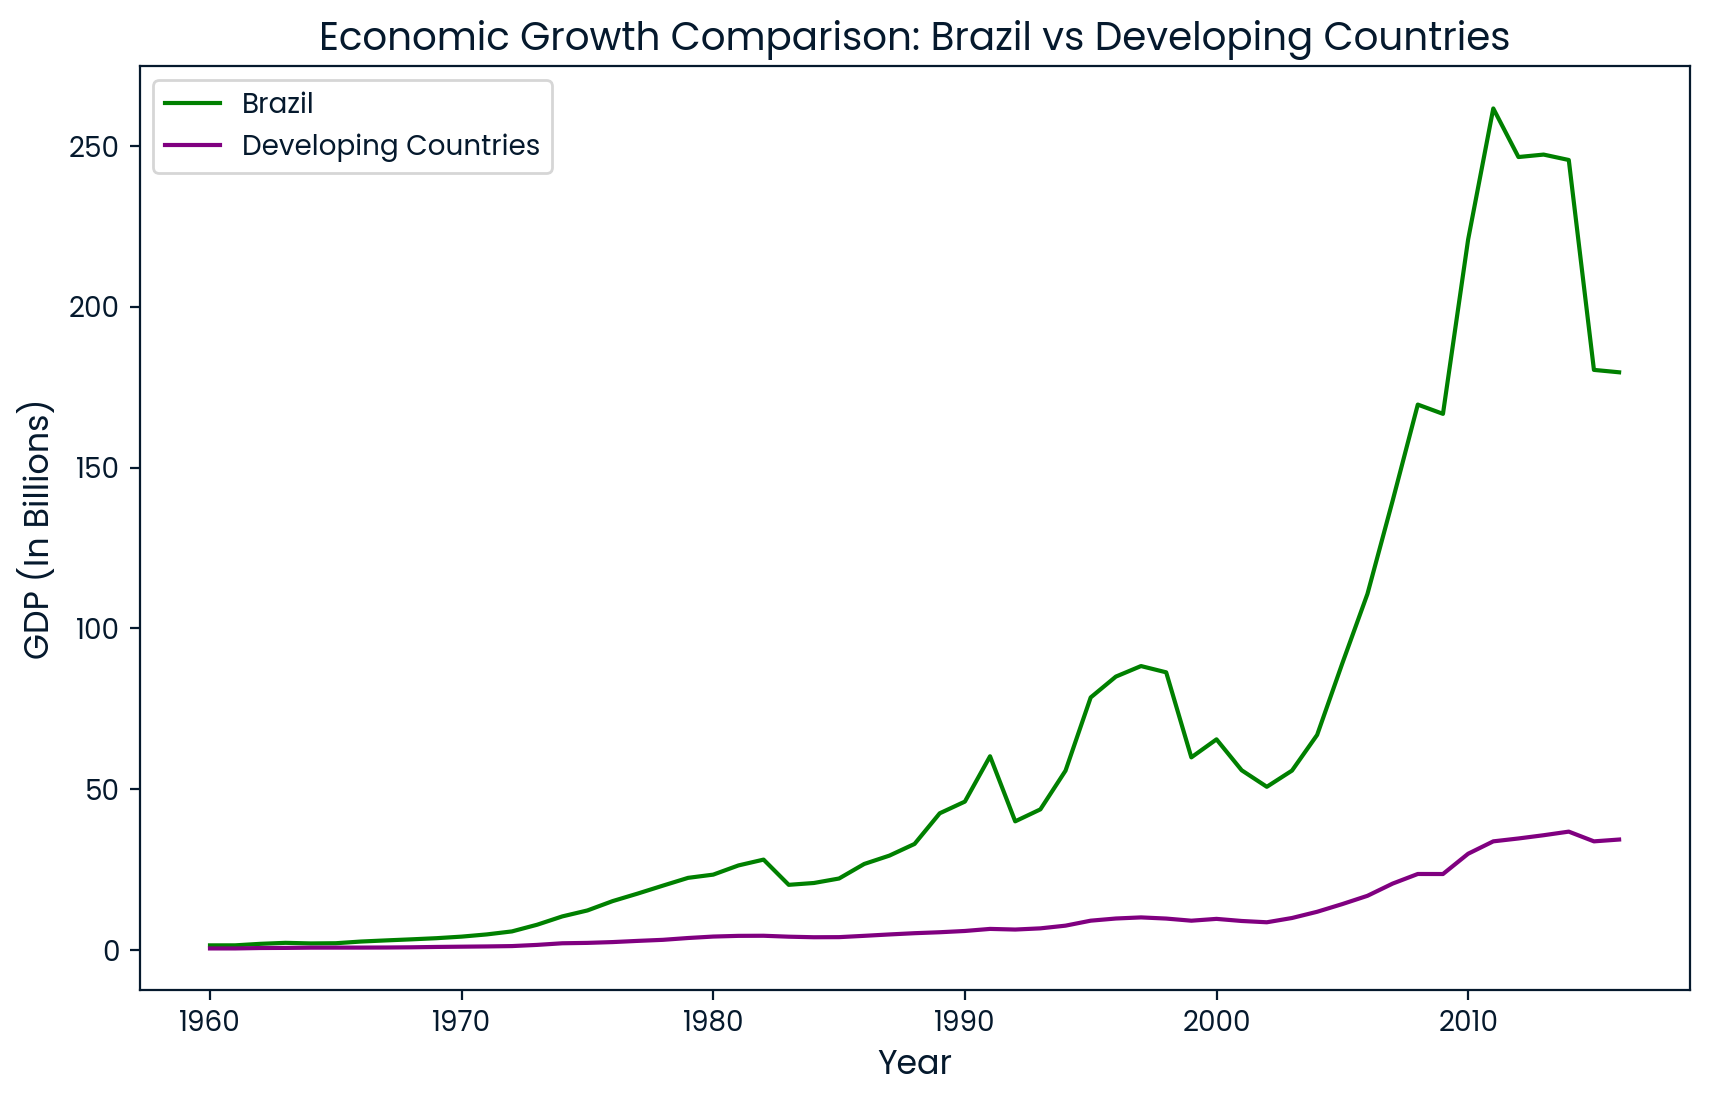

In [12]:
# Brazil Data
brazil_data = gdp_data_cleaned[gdp_data_cleaned['Country Code'] == 'BRA']

# In Development Countries Data
in_development_data = gdp_data_cleaned[gdp_data_cleaned['is_developed'] == False]
gdp_in_development = in_development_data.groupby('Year')['Value'].mean().reset_index()

# Visual
plt.figure(figsize=(10, 6))
sns.lineplot(data=brazil_data, x='Year', y=brazil_data['Value'] / 1e10, label='Brazil', color='green', ci=None)
sns.lineplot(data=gdp_in_development, x='Year', y=gdp_in_development['Value'] / 1e10, label='Developing Countries', color='purple', ci=None)
plt.title('Economic Growth Comparison: Brazil vs Developing Countries', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (In Billions)', fontsize=12)
plt.legend()
plt.show()


### Economic Growth Calculation

I thought it would be interesting to show how the GDP of BRICS countries changes on average over the years rather than showing a raw sum.

In [13]:
# BRICS Data
brics_countries = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF']
brics_data = gdp_data[gdp_data['Country Code'].isin(brics_countries)]

# % Variation by year
brics_data['Growth'] = brics_data.groupby('Country Code')['Value'].pct_change() * 100

# Treating outliers and null values
brics_data['Growth'] = brics_data['Growth'].fillna(0)
q1 = brics_data['Growth'].quantile(0.25)
q3 = brics_data['Growth'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
brics_data['Growth'] = np.clip(brics_data['Growth'], lower_bound, upper_bound)

### Anual BRICS Growth increase

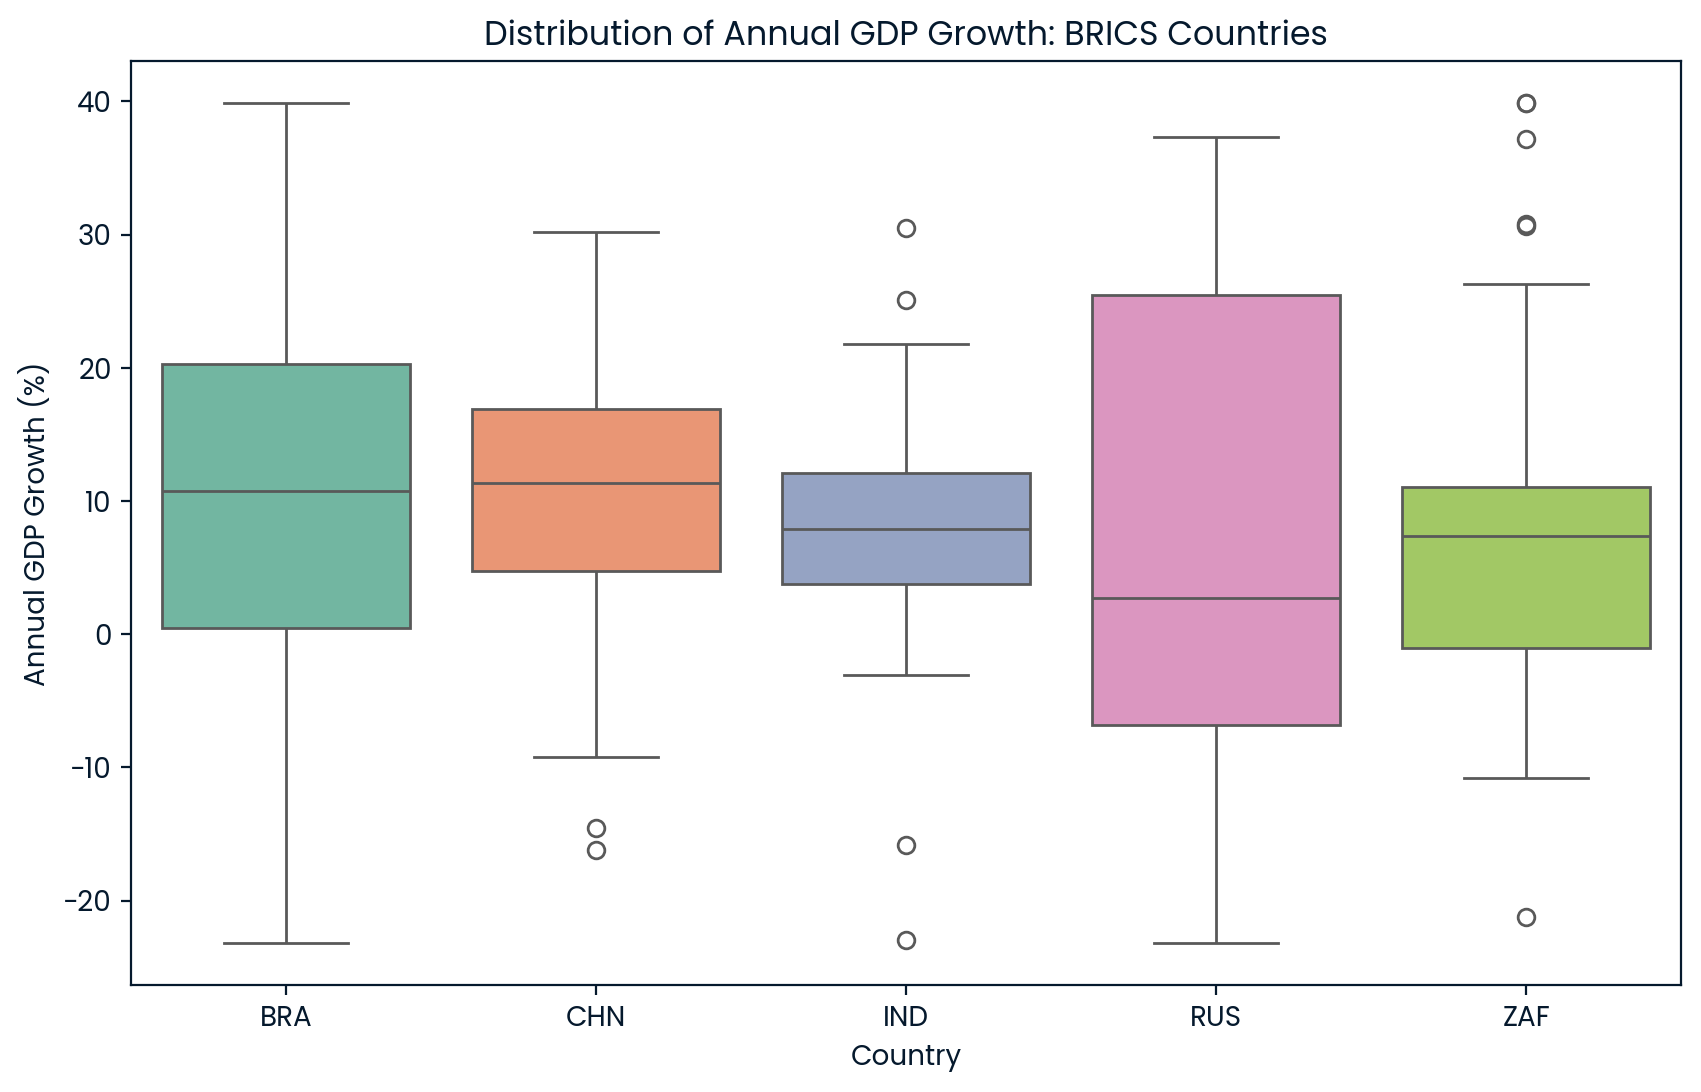

In [14]:
# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=brics_data, x='Country Code', y='Growth', palette='Set2')
plt.title('Distribution of Annual GDP Growth: BRICS Countries')
plt.xlabel('Country')
plt.ylabel('Annual GDP Growth (%)')
plt.show()

## HDI and Life Expectancy

### HDI in South America  
South American countries in relation to the HDI.

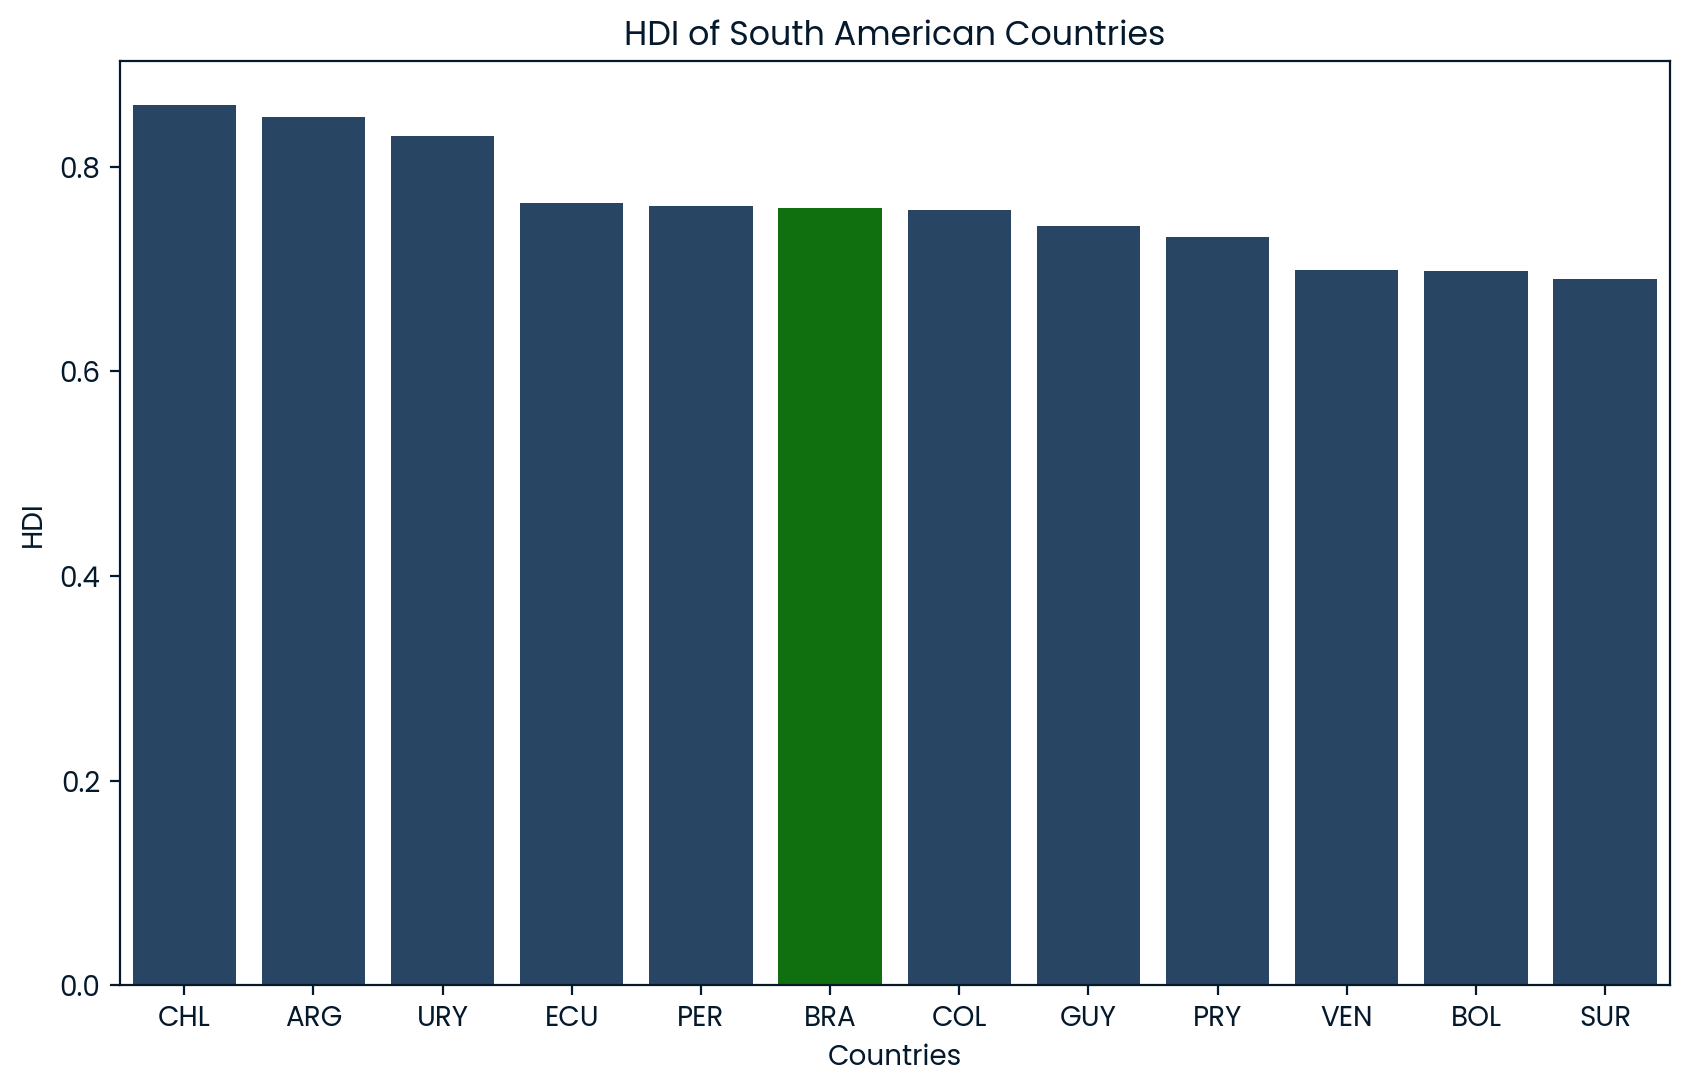

In [15]:
# Filter South American countries
south_american_countries = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']
south_american_data = world_data[world_data['iso3'].isin(south_american_countries)].sort_values('hdi_2022', ascending=False)

# Colors for the chart
south_american_data['color'] = south_american_data['iso3'].apply(lambda x: 'green' if x == 'BRA' else '#1F456E')

# HDI Visualization for South America
plt.figure(figsize=(10, 6))
sns.barplot(data=south_american_data, x='iso3', y='hdi_2022', palette=south_american_data['color'].to_list())
plt.xlabel('Countries')
plt.ylabel('HDI')
plt.title('HDI of South American Countries')
plt.show()


## Where does Brazil stand in relation to life expectancy and HDI?

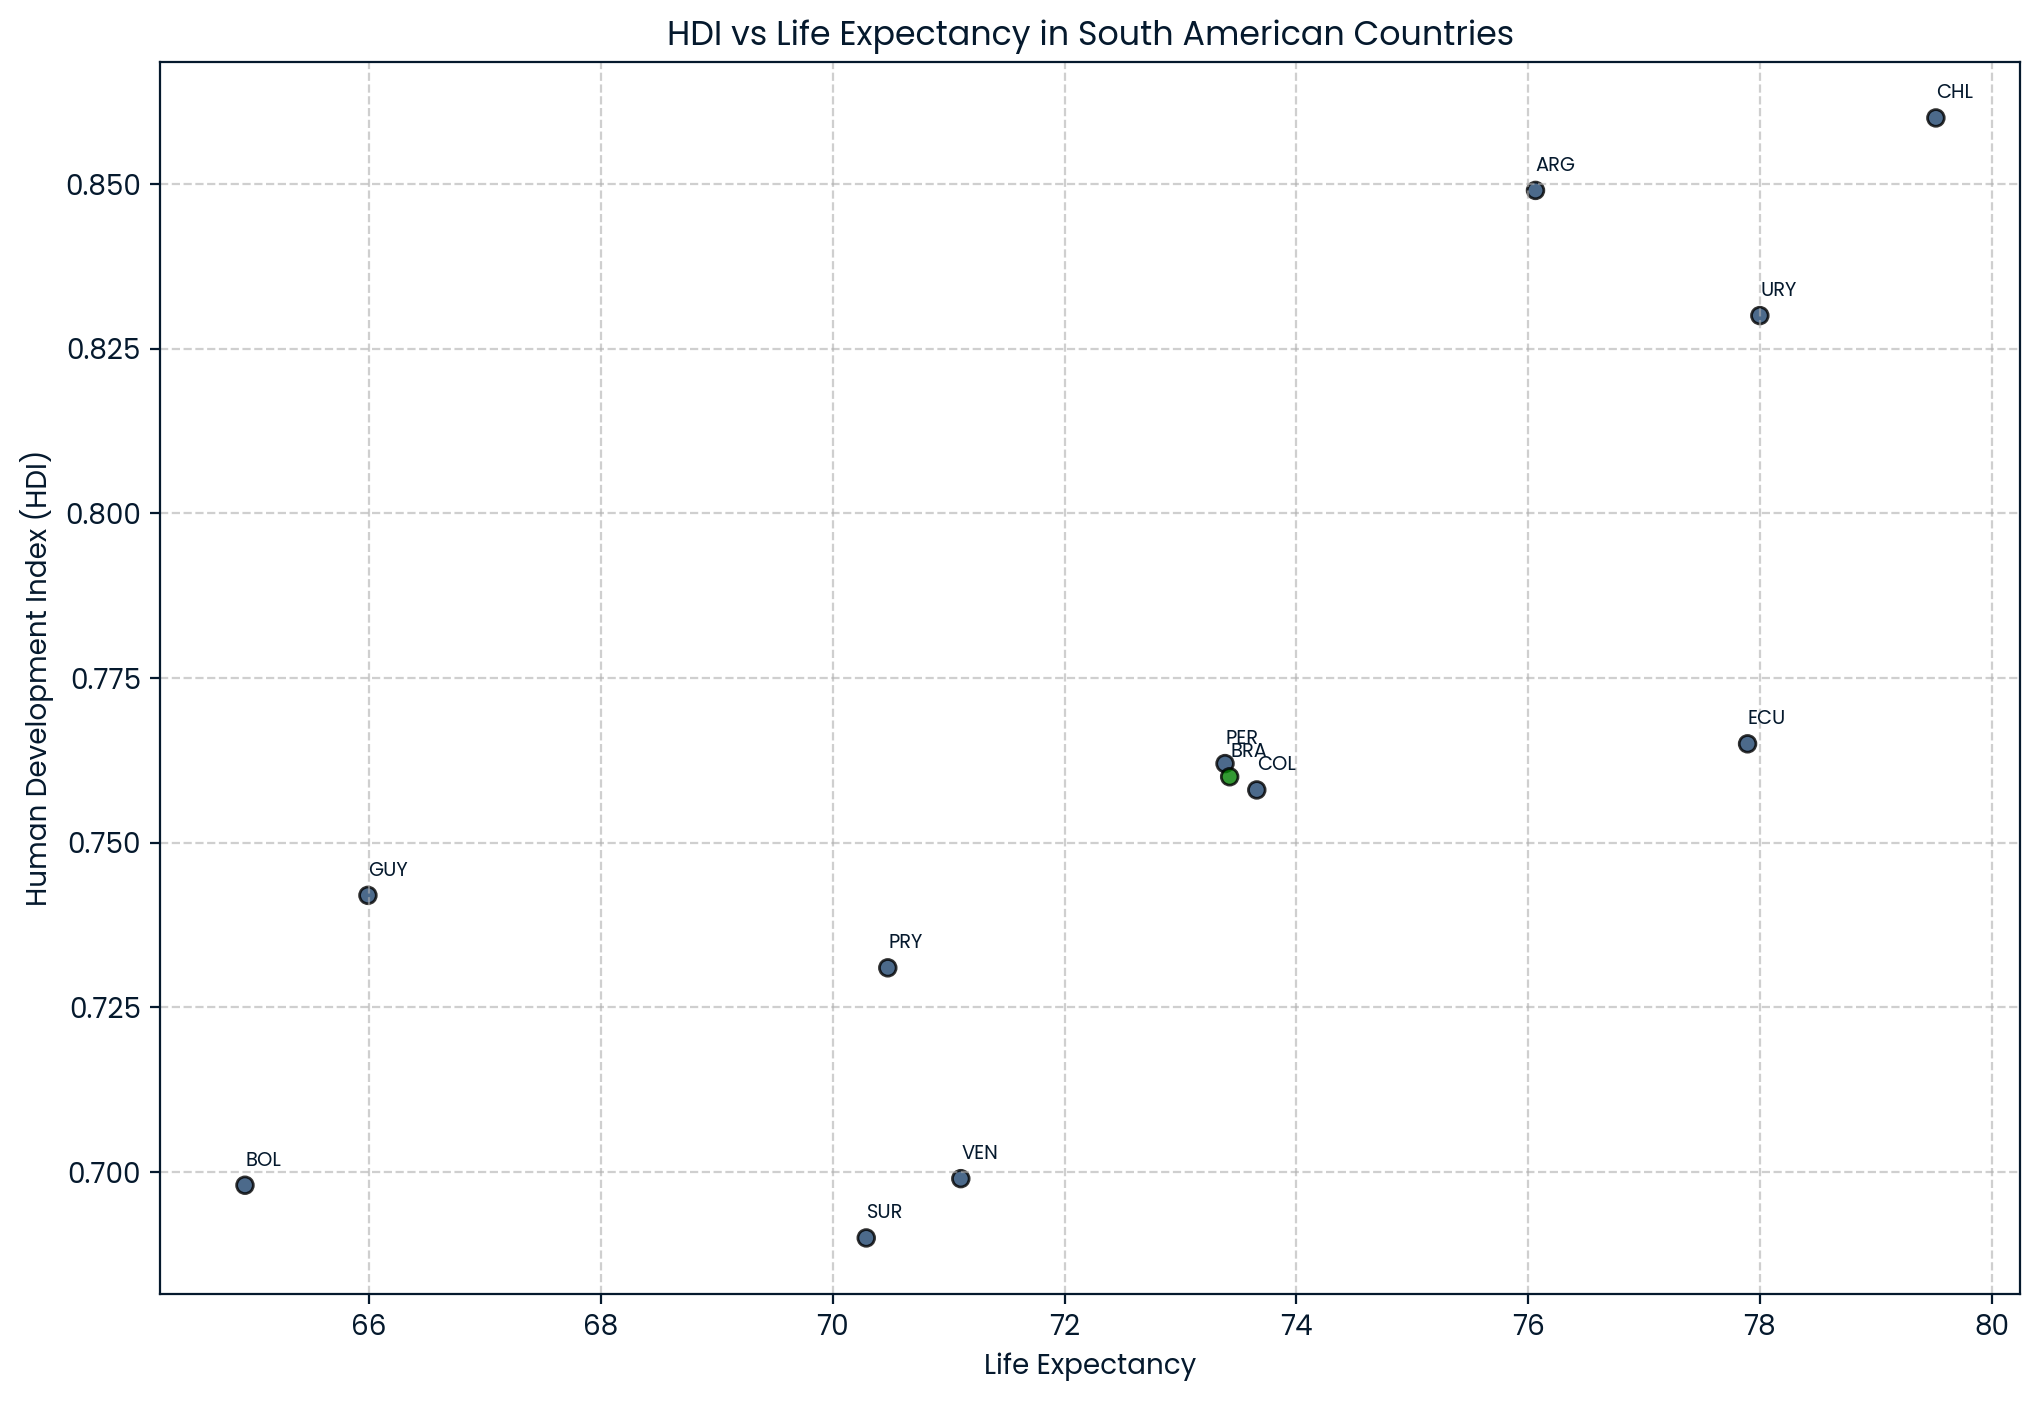

In [16]:
# Correlation between life expectancy and HDI
plt.figure(figsize=(12, 8))
plt.scatter(south_american_data['le_2022'], south_american_data['hdi_2022'], color=south_american_data['color'], alpha=0.8, edgecolor='k')
for i, row in south_american_data.iterrows():
    plt.text(x=row['le_2022'] + 0.003, y=row['hdi_2022'] + 0.003, s=row['iso3'], fontsize=7)
plt.xlabel('Life Expectancy')
plt.ylabel('Human Development Index (HDI)')
plt.title('HDI vs Life Expectancy in South American Countries')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Conclusion
- Brazil shows economic growth in line with other developing countries, but faces comparative challenges.
- Countries with higher life expectancy tend to have higher HDI, highlighting the relationship between quality of life and human development.
- Despite Brazil’s prominence among the BRICS and developing countries, it still struggles to reflect its growth within the population, as evidenced by its mediocre performance when compared to South America.

These results highlight the importance of policies focused on both economic growth and improvements in social indicators.